# **MScFE690 Capstone Project: Draft Project (Module 6)**

**A Capstone Project Submitted for the Award of Master of Science in Financial Engineering at WorldQuant University**

- **Calvin Emmy Okello (Uganda):** okellocalvinemmy@gmail.com
- **Kyaw Lin Oo (Country):** klo.kyawlinoo99@gmail.com
- **Mohammad Ilyas Zewar (Afghanistan):** m.ilyas.zewar@gmail.com

In [ ]:
import warnings
warnings.filterwarnings("ignore")

try:
  import diagrams
except:
  !pip install diagrams --quiet
  import diagrams

try:
  from pmdarima.arima import auto_arima
except:
  !pip install pmdarima --quiet
  from pmdarima.arima import auto_arima

try:
  from arch import arch_model
except:
  !pip install arch --quiet
  from arch import arch_model

import pandas as pd, numpy as np, matplotlib.pyplot as plt, yfinance as yf, datetime as dt
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.decomposition import PCA

# Setting Figures Size
plt.rcParams["figure.figsize"] = (10, 4)

## **3 Study Materials and Methods**

### **3.1 Scope of the Study**

#### **3.1.1 Time Scope:**


The study shall be conducted on daily price data for 10 years. The first 6 years shall be used as in sample datasets for the time series modeling of the sub-indices whereas the remaining 4 years data shall be used as out of sample dataset for the time series modeling of the sub-indices. This shall be referred to as Phase 1 modeling.
The phase 1 out of sample predictions for sub-indices shall be recombined with index fund actual prices to form raw data for Phase 2 modeling. The first 3 years of phase 2 raw data shall constitute the in-sample data set whereas the last 1 year shall constitute the out of the sample data set.

In [ ]:
# web scraping list of Dow 30 subindices
djia_indices = pd.read_html('https://www.investopedia.com/terms/d/dow-30.asp')
djia_indices = pd.DataFrame(np.array(djia_indices)[0], columns = ["Company", "Symbol", "Year Added"])
djia_indices.sort_values("Year Added", ascending = False, inplace = True)
djia_indices.reset_index(inplace = True, drop = True)
djia_indices

,Company,Symbol,Year Added
0,Amazon.com,AMZN,2024
1,Salesforce,CRM,2020
2,Amgen,AMGN,2020
3,Honeywell,HON,2020
4,Dow,DOW,2019
5,Apple,AAPL,2015
6,NIKE,NKE,2013
7,Visa,V,2013
8,Goldman Sachs,GS,2013
9,UnitedHealth Group,UNH,2012


#### **3.1.2 Content Scope:**

The study shall involve Dow Jones Industrial Average sub-indices whose prices are highly correlated with the price of the index fund (Dow Jones Industrial Average) within the training set. The study shall consider prices for top 5 subindices which are most correlated with the index fund price. The study shall exclude subindices that have not spent 10 years by 31st December 2023 as a sub-index of Dow Jones Industrial Average.

In [ ]:
# Subindices that had spent at least 10 years by December 31st, 2023
djia_indices_10yrs = djia_indices[djia_indices["Year Added"] < 2014]
djia_indices_10yrs.reset_index(inplace = True, drop = True)
djia_indices_10yrs

,Company,Symbol,Year Added
0,NIKE,NKE,2013
1,Visa,V,2013
2,Goldman Sachs,GS,2013
3,UnitedHealth Group,UNH,2012
4,Cisco Systems,CSCO,2009
5,The Travelers Companies,TRV,2009
6,Chevron,CVX,2008
7,Verizon,VZ,2004
8,Microsoft,MSFT,1999
9,The Home Depot,HD,1999


In [ ]:
# Adding index fund (Dow Jone Industrial Avearage)
djia_indices_10yrs.loc[len(djia_indices_10yrs.index)] = ["Dow Jones Industrial Average", "^DJI", 1885]
djia_indices_10yrs.dropna(inplace = True)
djia_indices_10yrs.drop_duplicates(subset = "Symbol", inplace = True)
djia_indices_10yrs.reset_index(drop = True, inplace = True)
djia_indices_10yrs

,Company,Symbol,Year Added
0,NIKE,NKE,2013
1,Visa,V,2013
2,Goldman Sachs,GS,2013
3,UnitedHealth Group,UNH,2012
4,Cisco Systems,CSCO,2009
5,The Travelers Companies,TRV,2009
6,Chevron,CVX,2008
7,Verizon,VZ,2004
8,Microsoft,MSFT,1999
9,The Home Depot,HD,1999


### **3.2 Data Retrieval**

The 30 companies that make up Dow Jones index fund as of July 2024 shall be extracted through web scraping with python panda’s html reader (pandas.read_html, 2024). The web page that will be scrapped shall be for Investopedia and the content will be the Dow Jones companies posted on 7th July 2024 (Chen, 2024).
The list will comprise of company name, symbol/ticker and the year the company was added to Dow Jones index fund. Only companies which were added within a period not less than 10 years will be used in sub-indices selection for model training.
Adjusted closing prices for the subindices and for index fund (Dow Jones Industrial Average) shall be downloaded through yahoo finance module in python (“yfinance”, 2024).

In [ ]:
# required dates for modeling both phase 1 and phase 2
start_date = "2014-01-01"
end_date = "2023-12-31"

# downloading adjusted closing prices for all subindices that have taken at least 10 yrs and for the index fund as well
djia_indices_10yrs_data = pd.DataFrame()
for ticker in djia_indices_10yrs["Symbol"]:
  ticker_data = pd.DataFrame(yf.download(ticker, start = start_date, end = end_date)["Adj Close"])
  ticker_data.rename(columns = {"Adj Close": ticker}, inplace = True)
  djia_indices_10yrs_data[ticker] = ticker_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
# Scaling the data
djia_indices_10yrs_data_scaled = StandardScaler().fit_transform(djia_indices_10yrs_data[djia_indices_10yrs_data.columns[: -1]])
djia_indices_10yrs_data_scaled = pd.DataFrame(djia_indices_10yrs_data_scaled, columns = djia_indices_10yrs_data.columns[: -1], index = djia_indices_10yrs_data.index)

# Fitting PCA to the scaled data
pca = PCA().fit(djia_indices_10yrs_data_scaled)
print(f"Percentage of PCA Explained Variances: \n", np.round(pca.explained_variance_ratio_ * 100, 0))

Percentage of PCA Explained Variances: 
 [73. 14.  4.  3.  2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index = djia_indices_10yrs_data_scaled.columns, columns = [f'PC{i + 1}' for i in range(loadings.shape[1])])
loadings_df = loadings_df.iloc[:, : 5] # We shall Focus on Explained Variance at 96% (first 5)

# Explained variance updated to 100 percent
explained_variance_100percent = pca.explained_variance_ratio_[: 5] / np.sum(pca.explained_variance_ratio_[: 5])

explained_variance_magnitude = pd.DataFrame(loadings_df * explained_variance_100percent).abs()
explained_variance_magnitude

,PC1,PC2,PC3,PC4,PC5
NKE,0.697056,0.032660,0.011929,0.002836,0.000461
V,0.745333,0.013592,0.002953,0.003337,0.000834
GS,0.691948,0.020661,0.000973,0.010309,0.001011
UNH,0.738206,0.024755,0.000752,0.000558,0.001869
CSCO,0.722604,0.026953,0.005511,0.002525,0.000528
TRV,0.719478,0.021930,0.007093,0.000806,0.002485
CVX,0.590203,0.073439,0.013315,0.001865,0.001611
VZ,0.453513,0.103548,0.008084,0.004962,0.001056
MSFT,0.738027,0.016358,0.007128,0.000174,0.000674
HD,0.747121,0.004269,0.004836,0.001095,0.000834


### **3.3 Variables/Sub-Indices Selection**


Pearson product-moment correlation coefficient (r) shall be used to determine the sub-indices which are most correlated with the index fund (Dow Jones Industrial Average). Pearson product-moment correlation coefficient (r) formula that shall be used to determine the correlation is shown below:


Where xi is the ith independent variable (sub index), y is the dependent variable (Dow Jones Industrial Average), x and y are means for independent and dependent variables respectively (NLC, 2024). The study shall consider the top 5 most correlated variables as independent variables and the index fund price as the dependent variable.

In [ ]:
# Getting correlation with Dow Jones Industrial Average and selecting top 5 indices
top5_pca_drivers = explained_variance_magnitude.sum(axis = 1).sort_values(ascending = False).iloc[: 5]
top5_pca_drivers.rename("Magnitude of Explained Variance", inplace = True)
top5_pca_drivers

,Magnitude of Explained Variance
UNH,0.766140
V,0.766050
MCD,0.764580
JPM,0.763454
MSFT,0.762361


### **3.4 Data Cleaning Process**

The data shall be checked for missing values and in case there are any, the study shall consider dropping the missing rows provided they are less than 5% of the rows of the entire dataset when all variables are combined into a single data frame. In case the columns with null values are greater than or equals to 5%, the nulls will be replaced through filling them with the most preceding record. This is majorly aimed at reducing huge variations/swings within a short duration of time which are associated with replacing nulls with means.

In [ ]:
# Getting the top 5 indices with higher correlation
selected_indices = list(top5_pca_drivers.index)
selected_indices.append("^DJI")
selected_indices

['UNH', 'V', 'MCD', 'JPM', 'MSFT', '^DJI']

In [ ]:
# Extracting Adj. Price data for the selected indices
study_data = djia_indices_10yrs_data[selected_indices]

# Looking for null values if any
study_data.isna().sum()

,0
UNH,0
V,0
MCD,0
JPM,0
MSFT,0
^DJI,0


In [ ]:
study_data.head(3)

,UNH,V,MCD,JPM,MSFT,^DJI
Date,,,,,,
2014-01-02 00:00:00+00:00,63.254967,51.229275,72.703751,43.285358,31.120729,16441.349609
2014-01-03 00:00:00+00:00,63.704544,51.264046,72.801826,43.619984,30.911367,16469.990234
2014-01-06 00:00:00+00:00,62.975025,50.955757,72.281471,43.872814,30.258137,16425.099609


### **3.5 Phase 1: Data Preprocessing and Time Series Analysis**

#### **3.5.1 Input Variables:**

The sub-index daily prices shall be converted into a daily log return data. The log return shall be used majorly because it compresses large amounts of variations/jumps into a smaller range as per the advice by (Rawle, 2023). This is expected to smoothen data during a regime switch since the scope of this study does not incorporate regime switch in the time series modeling.

#### **3.5.2 Data Training, Validation and Testing:**

Several time series analysis techniques such as Auto-Regressive Integrated Moving Average (ARIMA), Generalized Autoregressive Conditional Heteroskedasticity (GARCH), Long Short-Term Memory (LSTM) among others shall be used and the model technique that output the lowest mean squared error shall be considered for sub-index modeling. Walk-Forward Optimization shall be used during modeling for better convergence of hyperparameters and improvement of model performance.

In [ ]:
phase1_data = study_data.iloc[:, : -1]
phase1_data.head(3)

,UNH,V,MCD,JPM,MSFT
Date,,,,,
2014-01-02 00:00:00+00:00,63.254967,51.229275,72.703751,43.285358,31.120729
2014-01-03 00:00:00+00:00,63.704544,51.264046,72.801826,43.619984,30.911367
2014-01-06 00:00:00+00:00,62.975025,50.955757,72.281471,43.872814,30.258137


In [ ]:
start_date = "2014-01-01"
end_date = "2023-12-31"

# setting time periods for phase 1
train_start = pd.to_datetime(dt.datetime.strptime(start_date, "%Y-%m-%d"))
train_end = pd.to_datetime(dt.datetime.strptime(end_date, "%Y-%m-%d"))
test_start = pd.to_datetime(train_end - relativedelta(years = 4) + dt.timedelta(days = 1))

In [ ]:
# splitting data into training and testing datasets
phase1_data.index = pd.to_datetime(phase1_data.index).tz_localize(None)
phase1_train_set = phase1_data.loc[train_start: test_start]
phase1_test_set = phase1_data.loc[test_start: ]
phase1_train_set.head(3)

,UNH,V,MCD,JPM,MSFT
Date,,,,,
2014-01-02,63.254967,51.229275,72.703751,43.285358,31.120729
2014-01-03,63.704544,51.264046,72.801826,43.619984,30.911367
2014-01-06,62.975025,50.955757,72.281471,43.872814,30.258137


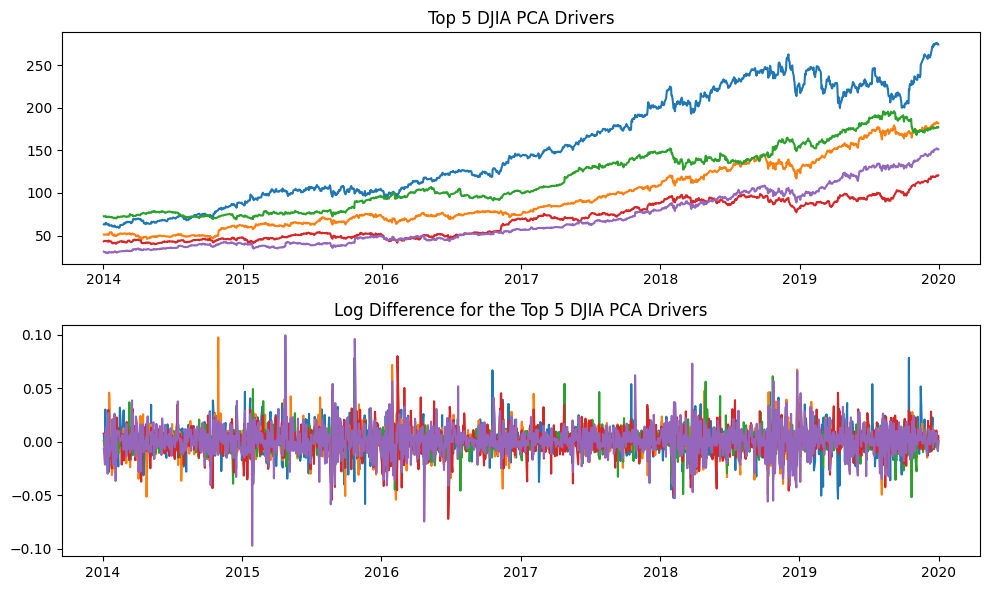

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 6))

ax1.plot(phase1_train_set)
ax1.set_title("Top 5 DJIA PCA Drivers")

ax2.plot(pd.DataFrame(np.log(phase1_train_set).diff().dropna()))
ax2.set_title("Log Difference for the Top 5 DJIA PCA Drivers")
fig.tight_layout()

#### **3.5.3 Modeling Individual Sub-Indices:**

For modeling purposes, we have started with defining various functions where the first function looks at the trend, log differences, ACF, PACF plots…etc for the selected sub-index and the second function is looking at the GARCH diagnostics for that particular sub-index.  The third function will model the data for the selected sub-index while the fourth one will provide the model predictions for the specified sub-index.

In [ ]:
def price_logdiff_acf_pacf(data, ticker):
  # Plotting stock prices
  data[f'{ticker}'].plot(figsize = (10, 1.5))
  plt.title(f"{ticker} Stock Price")
  plt.ylabel("Stock Price")
  plt.xlabel("Time")

  # ACF and PACF Plots for Stock Price
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 1.5))
  sm.graphics.tsa.plot_acf(data[f'{ticker}'], title = f"{ticker} Stock Price ACF", lags = 30, ax = ax1)
  sm.graphics.tsa.plot_pacf(data[f'{ticker}'], title = f"{ticker} Stock Price PACF", lags = 30, ax = ax2)

  #Plotting log differences
  log_diff_data = np.log(data[f'{ticker}']).diff().dropna()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 1.5))
  ax1.plot(log_diff_data)
  ax1.set_title(f"First Difference of Log {ticker} Stock Price")

  x = np.linspace(min(log_diff_data), max(log_diff_data), len(log_diff_data))
  values, bins, _ = ax2.hist(log_diff_data, bins = 50)  # Histogram

  (mu, sigma) = stats.norm.fit(log_diff_data)
  ax2.plot(x, stats.norm.pdf(x, mu, sigma) * sum(values * np.diff(bins)), "r")  # Density
  ax2.set_title(f"Histogram for {ticker} Prices Log Difference")

  # Normal QQ Plot f0r MCD stock prices Log difference
  qq = sm.qqplot(log_diff_data, stats.norm, fit = True, line = "q")
  qq.set_size_inches((10, 1.5))
  plt.title(f"Normal QQ Plot for {ticker} Prices Log Difference")

  # ACF and PACF Plots for log difference of Stock Prices
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 1.5))
  sm.graphics.tsa.plot_acf(log_diff_data, title = f"ACF for Log Difference of {ticker} Prices", lags = 30, ax = ax1)
  sm.graphics.tsa.plot_pacf(log_diff_data, title=f"PACF for Log Difference of {ticker} Prices", lags = 30, ax = ax2)

In [ ]:
# garch Diagnostic
def garch_diagnostic(data, p, q, ticker, dist = 'StudentsT'):
  # Log Return
  data = np.log(data[f'{ticker}']).diff().dropna()

  # GARCH(p, q) Model with Student's t White Noise
  garchpq_t_spec = arch_model(data, vol = "GARCH", p = p, q = q, mean = "AR", dist = dist, rescale = True)
  garchpq_t_fit = garchpq_t_spec.fit()

  # Model Diagnostic Plots for the GARCH(p,q) Model with Student's t White Noise
  fig, ax = plt.subplots(3, 3, figsize = (10, 6))

  # Figure Row 1 Column 1
  ax[0, 0].plot(data)
  ax[0, 0].plot(2.0 * garchpq_t_fit.conditional_volatility / 100.0, c = "r")
  ax[0, 0].plot(-2.0 * garchpq_t_fit.conditional_volatility / 100.0, c = "r")
  ax[0, 0].tick_params(labelrotation = 45)
  ax[0, 0].set_title("Series with 2 Conditional SD")
  ax[0, 0].set_ylabel("Returns")

  # Figure Row 1 Column 2
  VaR_1 = stats.t(df = len(data) - 1).ppf(0.99)
  # VaR_1 = stats.norm.ppf(0.99)
  ax[0, 1].plot(data)
  ax[0, 1].plot(VaR_1 * garchpq_t_fit.conditional_volatility / 100.0, c = "r")
  ax[0, 1].plot(-VaR_1 * garchpq_t_fit.conditional_volatility / 100.0, c = "r")
  ax[0, 1].tick_params(labelrotation = 45)
  ax[0, 1].set_title("Series with 1% VaR Limits")
  ax[0, 1].set_ylabel("Returns")

  # Figure Row 1 Column 3
  sm.graphics.tsa.plot_acf(garchpq_t_fit.resid / 100.0, lags = 20, ax = ax[0, 2])
  ax[0, 2].set_title("ACF of Observations")
  ax[0, 2].set_ylim([-0.2, 0.2])

  # Figure Row 2 Column 1
  sm.graphics.tsa.plot_acf(garchpq_t_fit.resid ** 2, lags = 20, ax = ax[1, 0])
  ax[1, 0].set_title("ACF of Squared Observations")
  ax[1, 0].set_ylim([-0.2, 0.2])

  # Figure Row 2 Column 2
  sm.graphics.tsa.plot_pacf(garchpq_t_fit.resid ** 2, lags = 20, ax = ax[1, 1])
  ax[1, 1].set_title("PACF of Squared Observations")
  ax[1, 1].set_ylim([-0.2, 0.2])

  # Figure Row 2 Column 3
  ax[1, 2].xcorr(garchpq_t_fit.resid ** 2, garchpq_t_fit.resid, usevlines = True, maxlags = 30, normed = True, lw = 2)
  ax[1, 2].set_title("Cross-Correlation of Squared Observations \n vs Actual Observation")

  # Figure Row 3 Column 1
  standaraized_residuals = garchpq_t_fit.std_resid
  min_val = np.min(standaraized_residuals)
  max_val = np.max(standaraized_residuals)
  empirical_density = np.linspace(min_val, max_val, len(standaraized_residuals))
  ax[2, 0].plot(empirical_density, stats.norm.pdf(empirical_density), lw = 1)
  ax[2, 0].set_title("Empirical Density of \n Standarized Residuals")

  # Figure Row 3 Column 2
  sm.qqplot(garchpq_t_fit.resid, stats.t, fit = True, line = "q", ax = ax[2, 1])
  ax[2, 1].set_title("StudentsT QQ-Plot")

  # Figure Row 3 Column 3
  sm.graphics.tsa.plot_acf((garchpq_t_fit.std_resid) ** 2, lags = 20, ax = ax[2, 2])
  ax[2, 2].set_title("ACF of Squared Standardized Residuals")
  ax[2, 2].set_ylim([-0.2, 0.2])
  fig.tight_layout()

In [ ]:
# GARCH(p, q) Model with Student's t and Normal White Noise
def p1_garch_modeling(price_data, ticker, p, q, dist, test_data = None, seed = 42):
  """
  dist can be 'StudentsT', or 'skewstudent' or 'normal'
  """
  #get log return
  data = np.log(price_data[f'{ticker}']).diff().dropna()
  test_data = np.log(test_data[f'{ticker}']).diff().dropna()

  # GARCH(p,q) Model with Student's t White Noise
  garchpq_t_spec = arch_model(data, vol = "GARCH", p = p, q = q, mean = "AR", dist = dist, rescale = True)
  garchpq_t_fit = garchpq_t_spec.fit()
  print('Model Summary')
  print(garchpq_t_fit.summary())

  if test_data.empty:
    np.random.seed(seed)
    predicted_volatility = np.empty()
    z_t = np.empty()
  else:
    np.random.seed(seed)
    time_steps = len(test_data)
    forecasts = garchpq_t_fit.forecast(horizon = time_steps)
    predicted_variance = forecasts.variance[-1: ]  # Extract the last row with the x-steps forecast
    predicted_volatility = np.sqrt(predicted_variance.values.flatten())  # Convert variance to volatility
    z_t = np.random.normal(size = time_steps)
  return predicted_volatility, z_t, predicted_volatility * z_t

In [ ]:
# price prediction
def price_prediction(price_data, ticker, p, q, dist, test_data, seed = 42):
  _, _, predictions = p1_garch_modeling(price_data, ticker, p, q, dist, test_data = test_data, seed = 42)

  predictions[0] = predictions[0] + price_data[f'{ticker}'][-1]
  predictions = pd.DataFrame(np.cumsum(predictions))
  predictions.index = test_data.index[1: ]

  predictions_log_diff = np.log(predictions).diff().dropna()
  test_log_diff = np.log(test_data[f'{ticker}']).diff().dropna()[1:]

  plt.figure(figsize = (10, 2.5))
  plt.plot(test_log_diff, c = 'r', label = 'Actual Log Difference')
  plt.plot(predictions_log_diff, c = 'b', label = 'Predicted Log Difference')
  plt.title(f'{ticker} Predicted Log Differences Vs {ticker} Actual Lof Differences')
  plt.legend()
  return predictions

##### **3.5.3.1 UNH Modeling Results**

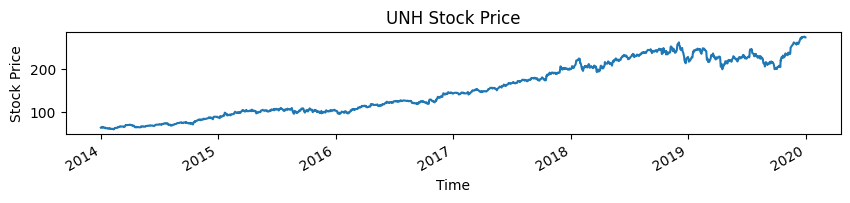

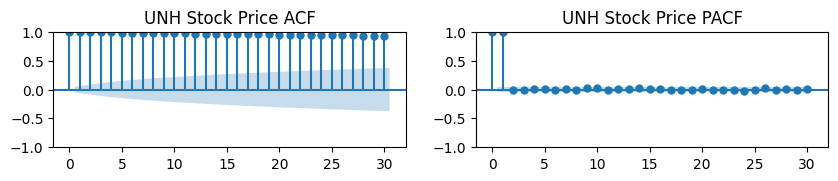

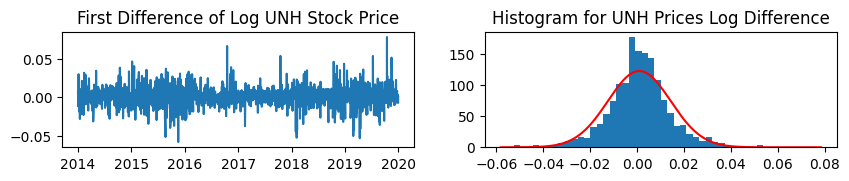

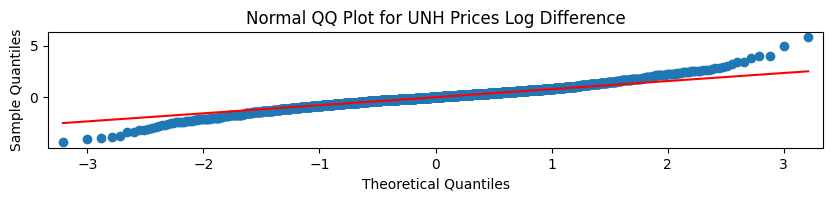

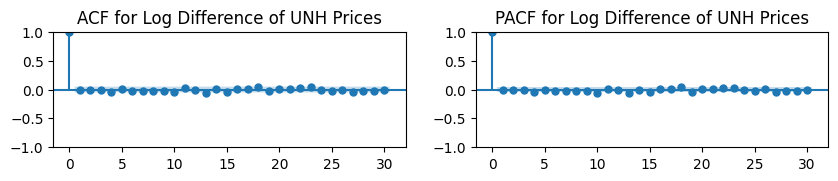

In [ ]:
price_logdiff_acf_pacf(phase1_train_set, "UNH")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 50394.90417388448
Iteration:      2,   Func. Count:     16,   Neg. LLF: 61593.334239160235
Iteration:      3,   Func. Count:     25,   Neg. LLF: 4545.03831649127
Iteration:      4,   Func. Count:     33,   Neg. LLF: 3771.4490790477475
Iteration:      5,   Func. Count:     40,   Neg. LLF: 2456.836816903225
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3776.425510108596
Iteration:      7,   Func. Count:     54,   Neg. LLF: 2462.06009150593
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2453.5279187496035
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2453.3623711566843
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2453.361110251927
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2453.3610466044033
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2453.3610466044047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2453.3610466044033
            Iterations:

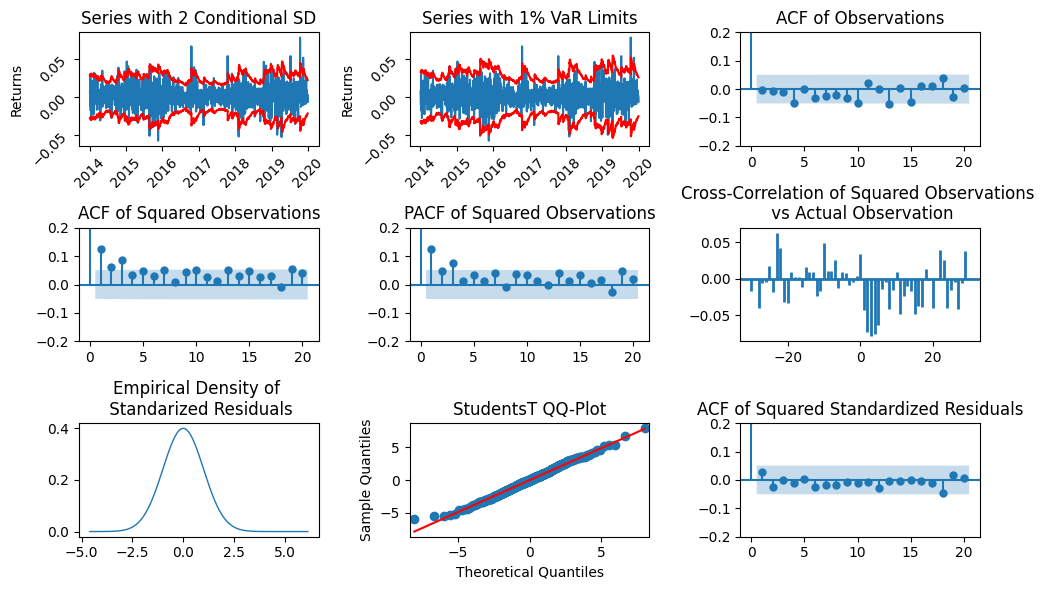

In [ ]:
garch_diagnostic(data = phase1_train_set,  p = 1, q = 1, ticker = "UNH")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 50394.90417388448
Iteration:      2,   Func. Count:     16,   Neg. LLF: 61593.334239160235
Iteration:      3,   Func. Count:     25,   Neg. LLF: 4545.03831649127
Iteration:      4,   Func. Count:     33,   Neg. LLF: 3771.4490790477475
Iteration:      5,   Func. Count:     40,   Neg. LLF: 2456.836816903225
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3776.425510108596
Iteration:      7,   Func. Count:     54,   Neg. LLF: 2462.06009150593
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2453.5279187496035
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2453.3623711566843
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2453.361110251927
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2453.3610466044033
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2453.3610466044047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2453.3610466044033
            Iterations:

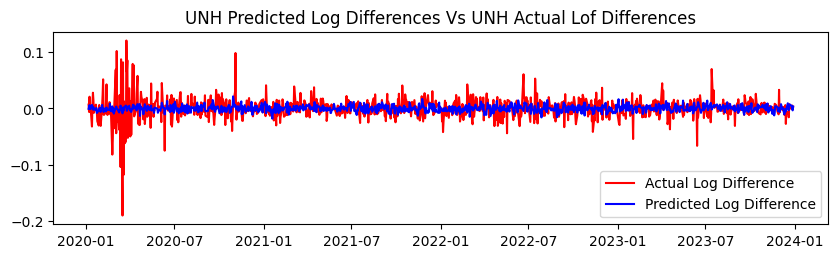

In [ ]:
predicted_unh = price_prediction(phase1_train_set, ticker = "UNH", p = 1, q = 1, dist = "StudentsT", test_data = phase1_test_set)

##### **3.5.3.2 V Modeling Results**

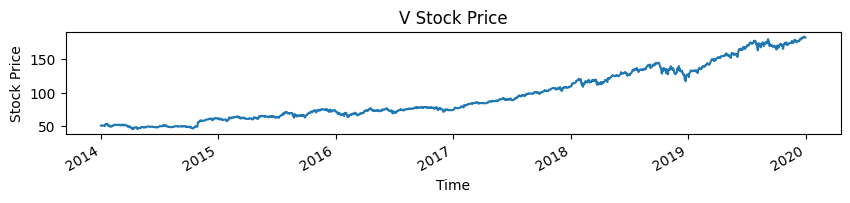

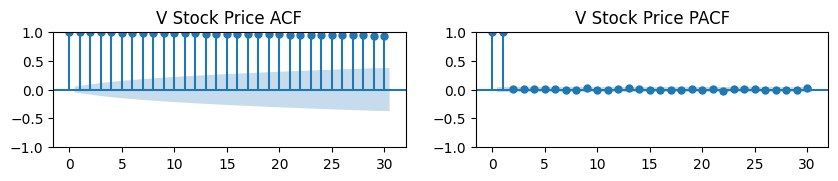

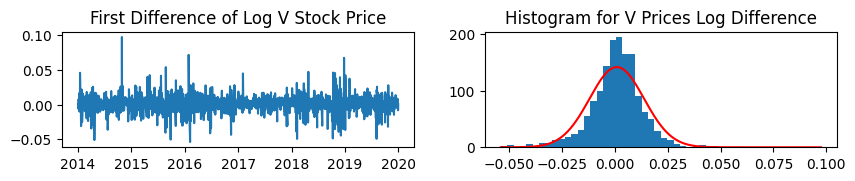

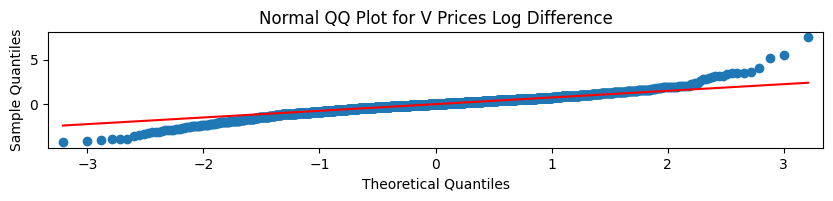

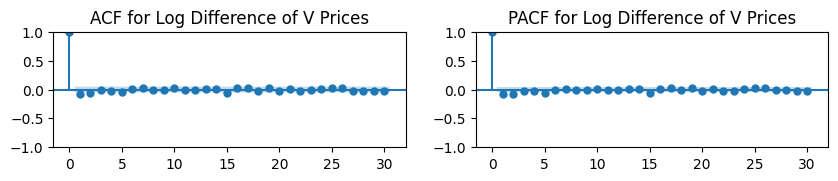

In [ ]:
price_logdiff_acf_pacf(phase1_train_set, "V")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 9557.124256502097
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4177.30959687375
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3765.1353250004886
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3498.3473565876125
Iteration:      5,   Func. Count:     39,   Neg. LLF: 2339.1855485393407
Iteration:      6,   Func. Count:     46,   Neg. LLF: 3660.320773131
Iteration:      7,   Func. Count:     54,   Neg. LLF: 2347.5080830312013
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2333.6643361334623
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2333.6635720409913
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2333.6635014926164
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2333.6635008934527
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2333.6635008934527
            Iterations: 11
            Function evaluations: 79
            Gradient evaluation

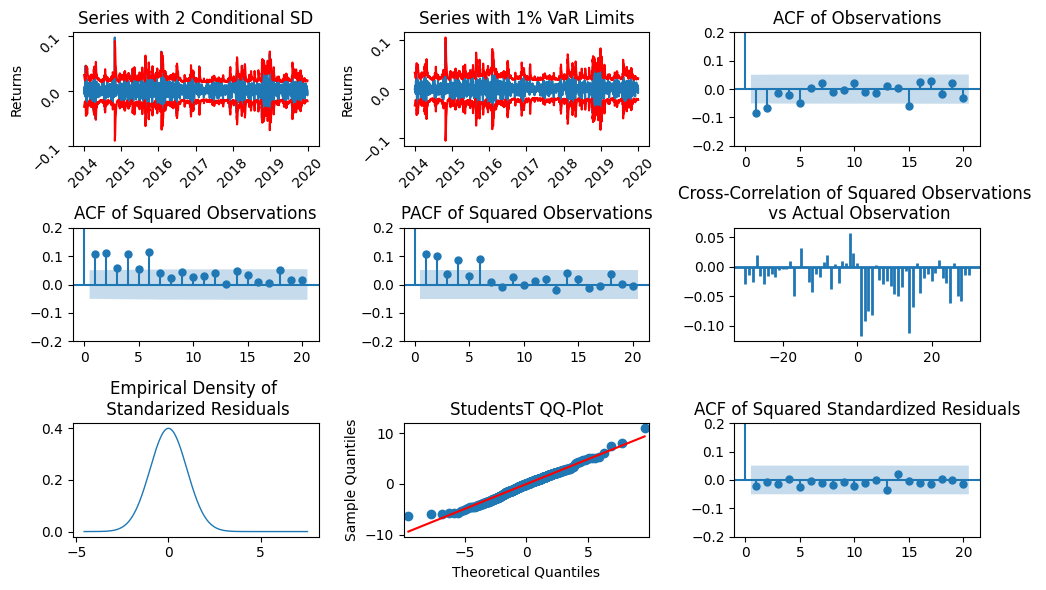

In [ ]:
garch_diagnostic(data = phase1_train_set,  p = 1, q = 1, ticker = "V")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 9557.124256502097
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4177.30959687375
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3765.1353250004886
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3498.3473565876125
Iteration:      5,   Func. Count:     39,   Neg. LLF: 2339.1855485393407
Iteration:      6,   Func. Count:     46,   Neg. LLF: 3660.320773131
Iteration:      7,   Func. Count:     54,   Neg. LLF: 2347.5080830312013
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2333.6643361334623
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2333.6635720409913
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2333.6635014926164
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2333.6635008934527
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2333.6635008934527
            Iterations: 11
            Function evaluations: 79
            Gradient evaluation

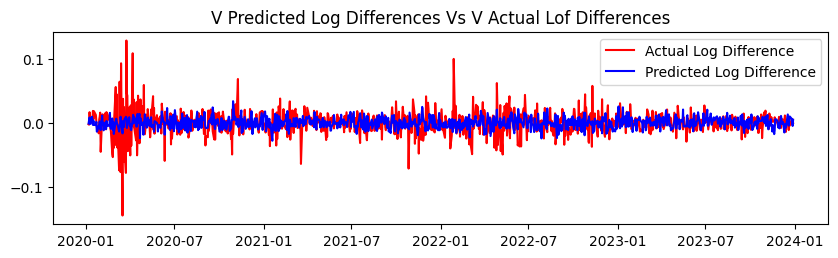

In [ ]:
predicted_v = price_prediction(phase1_train_set, ticker = "V", p = 1, q = 1, dist = "StudentsT", test_data = phase1_test_set)

##### **3.5.3.3 MCD Modeling Results**

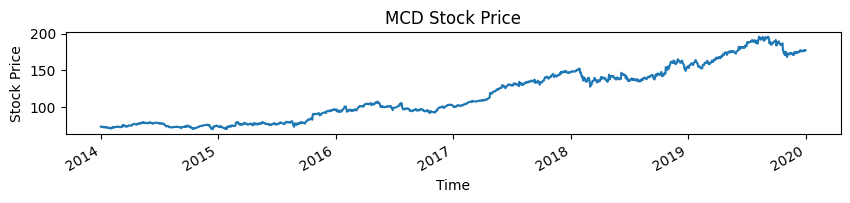

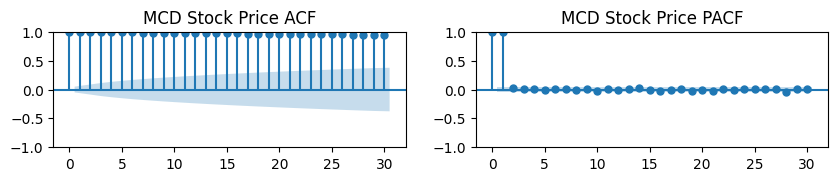

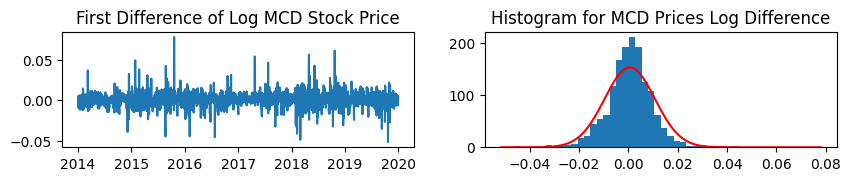

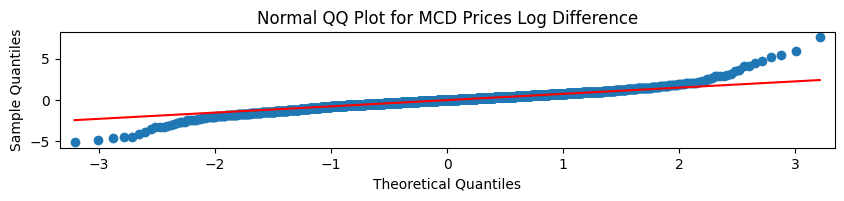

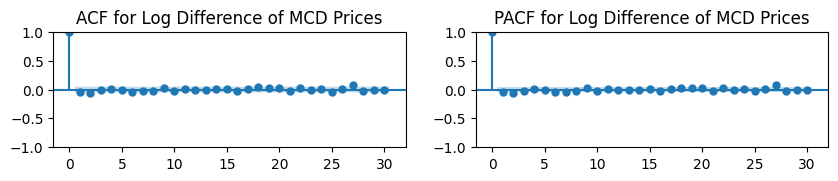

In [ ]:
price_logdiff_acf_pacf(phase1_train_set, "MCD")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 46191.39779881113
Iteration:      2,   Func. Count:     17,   Neg. LLF: 23308.1382965706
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2140.847635119466
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3219.1489690845974
Iteration:      5,   Func. Count:     39,   Neg. LLF: 2003.8900191457774
Iteration:      6,   Func. Count:     46,   Neg. LLF: 2773.32298640647
Iteration:      7,   Func. Count:     53,   Neg. LLF: 1996.6071910609478
Iteration:      8,   Func. Count:     60,   Neg. LLF: 1989.5901521164171
Iteration:      9,   Func. Count:     66,   Neg. LLF: 1989.5261282474435
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1989.4157714215798
Iteration:     11,   Func. Count:     80,   Neg. LLF: 1989.3157471885734
Iteration:     12,   Func. Count:     86,   Neg. LLF: 1989.3126594514108
Iteration:     13,   Func. Count:     92,   Neg. LLF: 1989.312448570466
Iteration:     14,   Func. Count:     98,   Neg. LLF: 1989

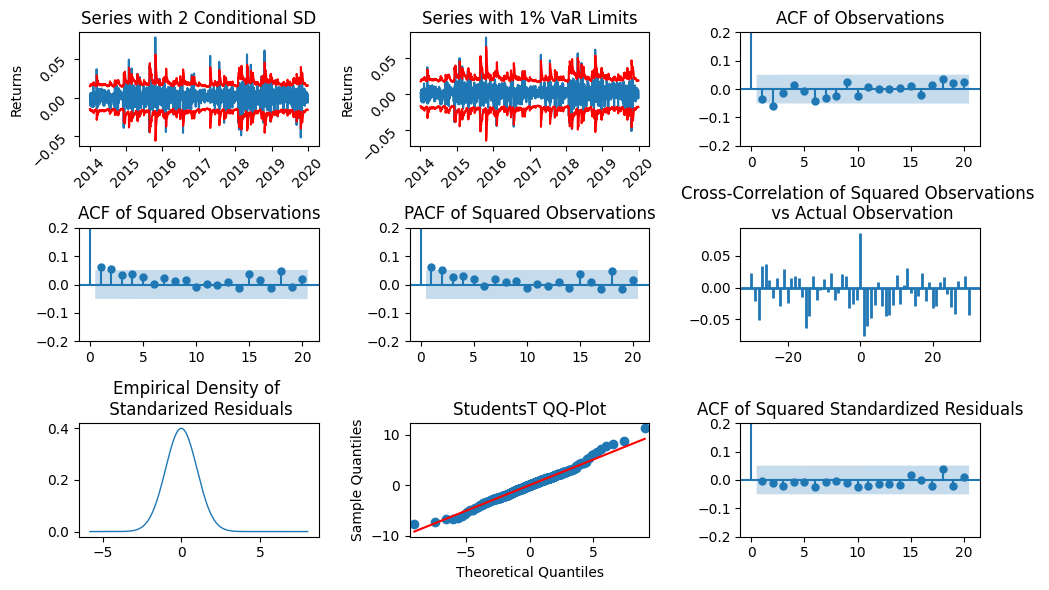

In [ ]:
garch_diagnostic(data = phase1_train_set,  p = 1, q = 1, ticker = "MCD")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 46191.39779881113
Iteration:      2,   Func. Count:     17,   Neg. LLF: 23308.1382965706
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2140.847635119466
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3219.1489690845974
Iteration:      5,   Func. Count:     39,   Neg. LLF: 2003.8900191457774
Iteration:      6,   Func. Count:     46,   Neg. LLF: 2773.32298640647
Iteration:      7,   Func. Count:     53,   Neg. LLF: 1996.6071910609478
Iteration:      8,   Func. Count:     60,   Neg. LLF: 1989.5901521164171
Iteration:      9,   Func. Count:     66,   Neg. LLF: 1989.5261282474435
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1989.4157714215798
Iteration:     11,   Func. Count:     80,   Neg. LLF: 1989.3157471885734
Iteration:     12,   Func. Count:     86,   Neg. LLF: 1989.3126594514108
Iteration:     13,   Func. Count:     92,   Neg. LLF: 1989.312448570466
Iteration:     14,   Func. Count:     98,   Neg. LLF: 1989

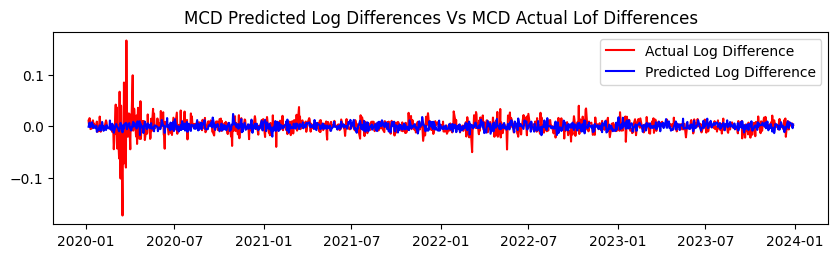

In [ ]:
predicted_mcd = price_prediction(phase1_train_set, ticker = "MCD", p = 1, q = 1, dist = "StudentsT", test_data = phase1_test_set)

##### **3.5.3.4 JPM Modeling Results**

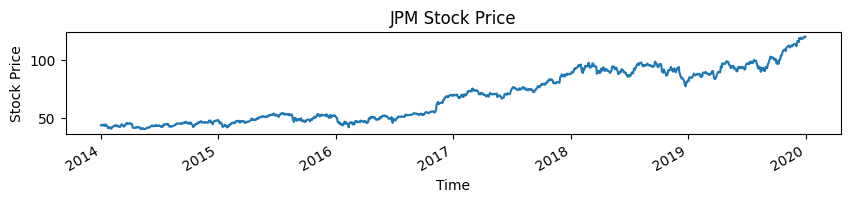

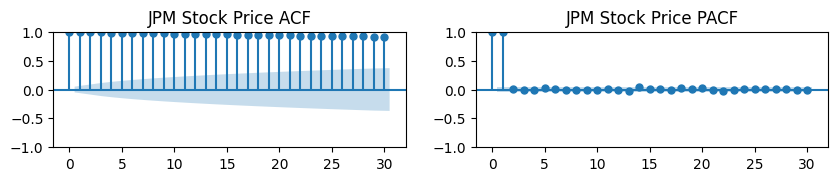

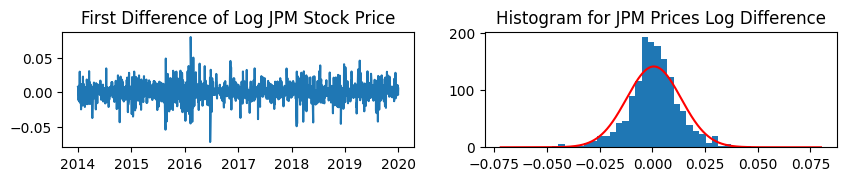

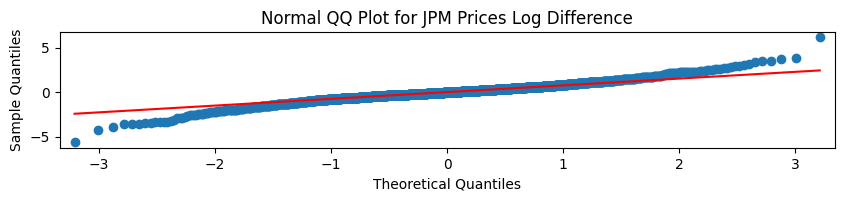

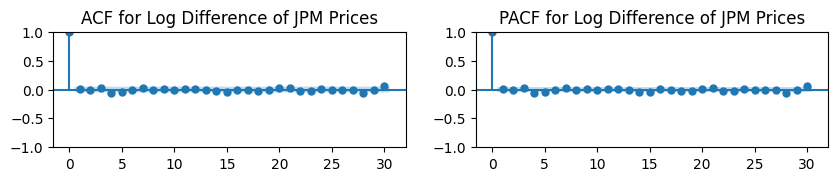

In [ ]:
price_logdiff_acf_pacf(phase1_train_set, "JPM")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 47595.18004773867
Iteration:      2,   Func. Count:     16,   Neg. LLF: 26406.639398726627
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4284.012855192017
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3691.576310680292
Iteration:      5,   Func. Count:     39,   Neg. LLF: 3712.5026808226266
Iteration:      6,   Func. Count:     46,   Neg. LLF: 3707.90700808806
Iteration:      7,   Func. Count:     53,   Neg. LLF: 2554.2455057906836
Iteration:      8,   Func. Count:     60,   Neg. LLF: 2403.508838980282
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2402.2678688617466
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2402.222017984779
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2402.214086607139
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2402.2121734205466
Iteration:     13,   Func. Count:     91,   Neg. LLF: 2402.2121229638965
Iteration:     14,   Func. Count:     96,   Neg. LLF: 2402.

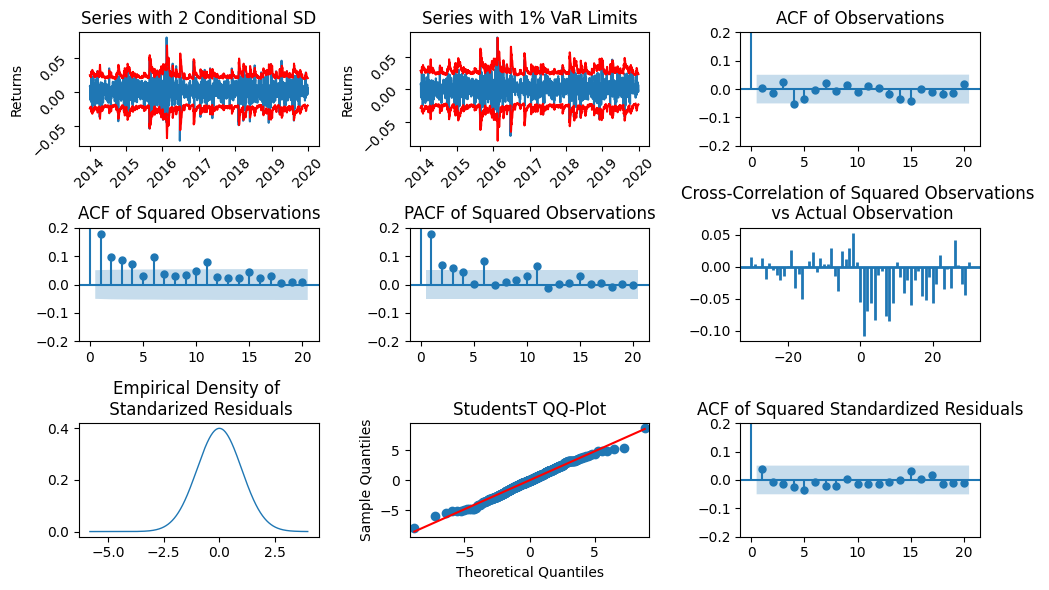

In [ ]:
garch_diagnostic(data = phase1_train_set,  p = 1, q = 1, ticker = "JPM")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 47595.18004773867
Iteration:      2,   Func. Count:     16,   Neg. LLF: 26406.639398726627
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4284.012855192017
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3691.576310680292
Iteration:      5,   Func. Count:     39,   Neg. LLF: 3712.5026808226266
Iteration:      6,   Func. Count:     46,   Neg. LLF: 3707.90700808806
Iteration:      7,   Func. Count:     53,   Neg. LLF: 2554.2455057906836
Iteration:      8,   Func. Count:     60,   Neg. LLF: 2403.508838980282
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2402.2678688617466
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2402.222017984779
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2402.214086607139
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2402.2121734205466
Iteration:     13,   Func. Count:     91,   Neg. LLF: 2402.2121229638965
Iteration:     14,   Func. Count:     96,   Neg. LLF: 2402.

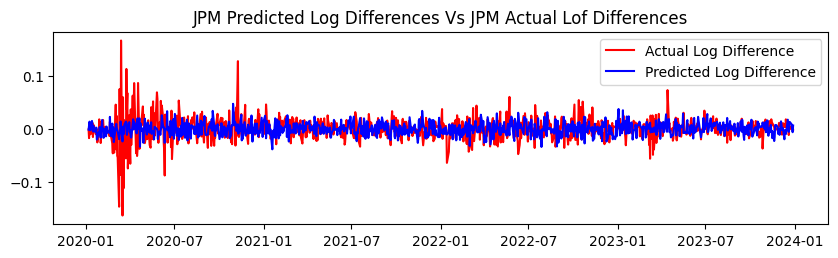

In [ ]:
predicted_jpm = price_prediction(phase1_train_set, ticker = "JPM", p = 1, q = 1, dist = "StudentsT", test_data = phase1_test_set)

##### **3.5.3.4 MSFT Modeling Results**

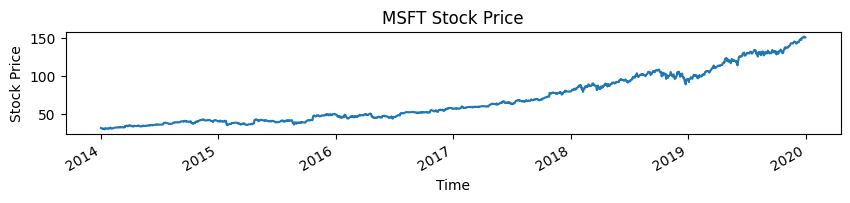

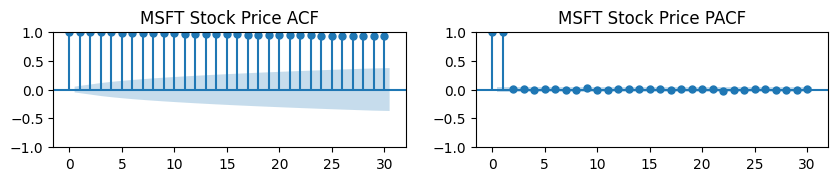

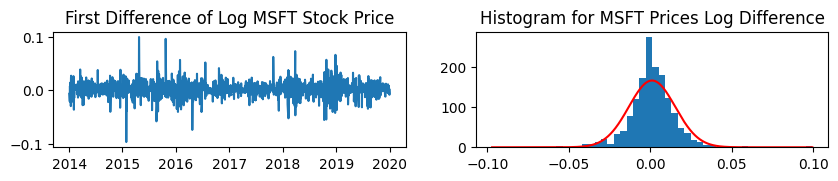

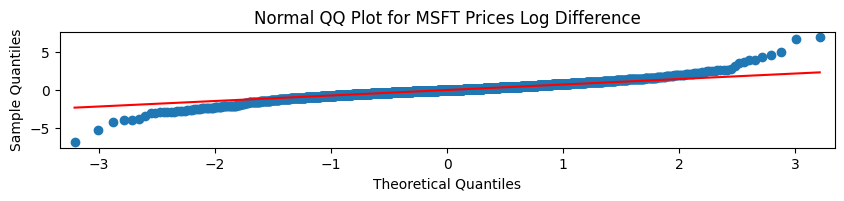

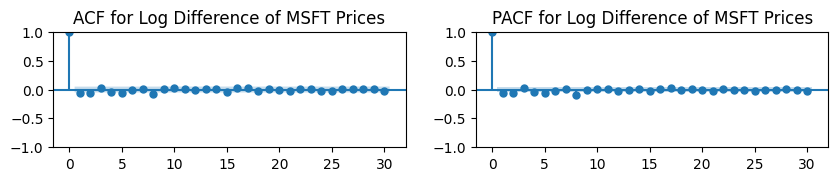

In [ ]:
price_logdiff_acf_pacf(phase1_train_set, "MSFT")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 41693.66022752198
Iteration:      2,   Func. Count:     16,   Neg. LLF: 24003.44636556912
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4175.042882047764
Iteration:      4,   Func. Count:     31,   Neg. LLF: 3568.2804382910435
Iteration:      5,   Func. Count:     38,   Neg. LLF: 2486.9312709968644
Iteration:      6,   Func. Count:     45,   Neg. LLF: 2540.3468579147197
Iteration:      7,   Func. Count:     52,   Neg. LLF: 2466.878891159432
Iteration:      8,   Func. Count:     59,   Neg. LLF: 2463.7772642597083
Iteration:      9,   Func. Count:     65,   Neg. LLF: 2463.7584906152624
Iteration:     10,   Func. Count:     71,   Neg. LLF: 2463.758077687742
Iteration:     11,   Func. Count:     77,   Neg. LLF: 2463.7580479664566
Iteration:     12,   Func. Count:     83,   Neg. LLF: 2463.758044961342
Iteration:     13,   Func. Count:     88,   Neg. LLF: 2463.7580449613297
Optimization terminated successfully    (Exit mode 0)
   

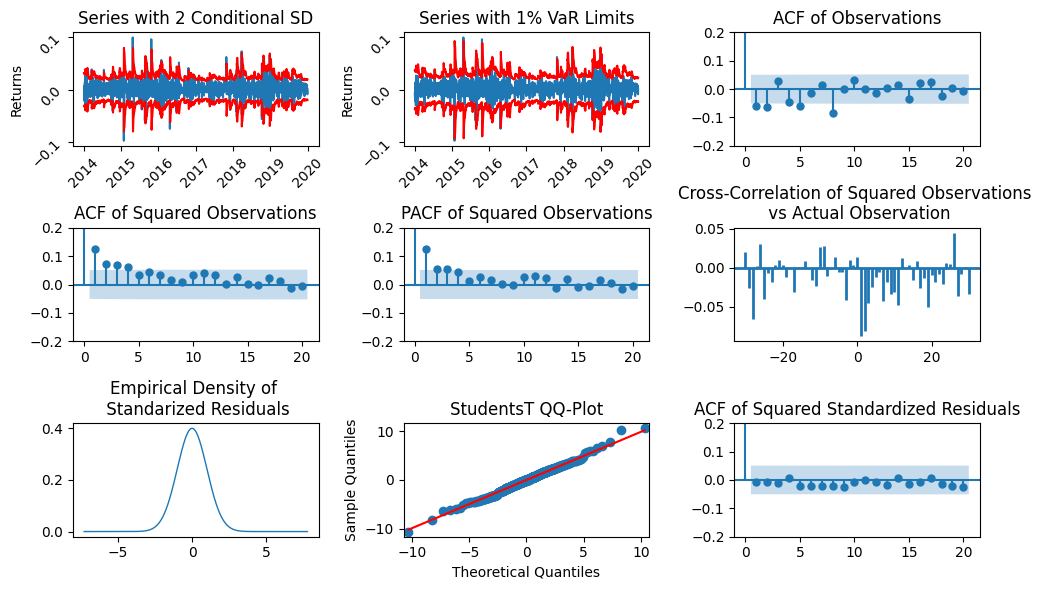

In [ ]:
garch_diagnostic(data = phase1_train_set,  p = 1, q = 1, ticker = "MSFT")

Iteration:      1,   Func. Count:      7,   Neg. LLF: 41693.66022752198
Iteration:      2,   Func. Count:     16,   Neg. LLF: 24003.44636556912
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4175.042882047764
Iteration:      4,   Func. Count:     31,   Neg. LLF: 3568.2804382910435
Iteration:      5,   Func. Count:     38,   Neg. LLF: 2486.9312709968644
Iteration:      6,   Func. Count:     45,   Neg. LLF: 2540.3468579147197
Iteration:      7,   Func. Count:     52,   Neg. LLF: 2466.878891159432
Iteration:      8,   Func. Count:     59,   Neg. LLF: 2463.7772642597083
Iteration:      9,   Func. Count:     65,   Neg. LLF: 2463.7584906152624
Iteration:     10,   Func. Count:     71,   Neg. LLF: 2463.758077687742
Iteration:     11,   Func. Count:     77,   Neg. LLF: 2463.7580479664566
Iteration:     12,   Func. Count:     83,   Neg. LLF: 2463.758044961342
Iteration:     13,   Func. Count:     88,   Neg. LLF: 2463.7580449613297
Optimization terminated successfully    (Exit mode 0)
   

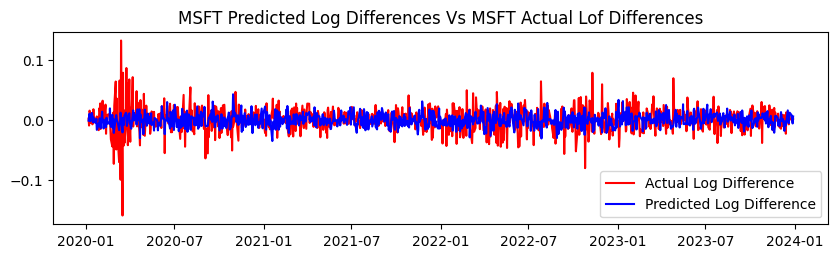

In [ ]:
predicted_msft = price_prediction(phase1_train_set, ticker = "MSFT", p = 1, q = 1, dist = "StudentsT", test_data = phase1_test_set)

#### **3.5.3 Output Data:**

In [ ]:
phase1_predictions = pd.concat([predicted_unh, predicted_v, predicted_mcd, predicted_jpm, predicted_msft], axis=1)
phase1_predictions.columns = ["UNH", "V", "MCD", "JPM", "MSFT"]
phase1_predictions.index = predicted_jpm.index

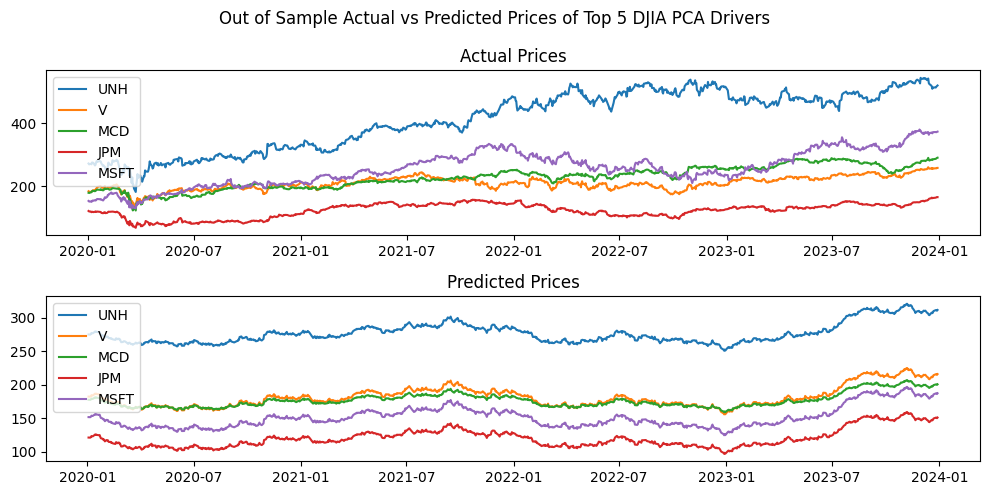

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 5))
fig.suptitle("Out of Sample Actual vs Predicted Prices of Top 5 DJIA PCA Drivers")

ax1.plot(phase1_test_set)
ax1.set_title("Actual Prices")
ax1.legend(labels = ["UNH", "V", "MCD", "JPM", "MSFT"])

ax2.plot(phase1_predictions)
ax2.set_title("Predicted Prices")
ax2.legend(labels = ["UNH", "V", "MCD", "JPM", "MSFT"])

fig.tight_layout();

In [ ]:
study_data.index = pd.to_datetime(study_data.index).tz_localize(None)
phase2_data = phase1_predictions.merge(study_data["^DJI"], left_index = True, right_index = True).dropna()
phase2_data.head(3)

,UNH,V,MCD,JPM,MSFT,^DJI
Date,,,,,,
2020-01-03,274.732787,182.169365,177.452554,121.137732,151.612047,28634.880859
2020-01-06,274.583142,182.037793,177.341481,120.994388,151.474631,28703.380859
2020-01-07,275.287562,182.685627,177.878045,121.688142,152.143702,28583.679688


### **3.6 Phase 2: Index Fund Replication Model Building**

The prediction results from the previous phase and the index fund price data shall be combined into a single data fram

#### **3.6.1 Input Data**

In [ ]:
train_start = np.min(phase2_data.index)
test_start = train_start + relativedelta(years = 3)
train_end = test_start - relativedelta(days = 1)
testing_end = np.max(phase2_data.index) + relativedelta(days = 1)

In [ ]:
X_train = pd.DataFrame(phase2_data.loc[: test_start].iloc[:, : 5], index = phase2_data.loc[: test_start].index)
y_train = pd.DataFrame(phase2_data.loc[: test_start].iloc[:, 5], index = phase2_data.loc[: test_start].index)
X_test = pd.DataFrame(phase2_data.loc[test_start: ].iloc[:, : 5], index = phase2_data.loc[test_start:].iloc[:, : 5].index)
y_test = pd.DataFrame(phase2_data.loc[test_start: ].iloc[:, 5], index = phase2_data.loc[test_start:].iloc[:, 5].index)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(756, 5)
(756, 1)
(250, 5)
(250, 1)


#### **3.6.2 Data Preprocessing**

To balance the impact of all variables and to improve the performance of the algorithm, the independent variables shall be rescaled into a range of 0 to 1 (Khoong, 2023).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scaling Data usign Min Max Scaler
scaler = MinMaxScaler(feature_range = (0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **3.6.3 Model Training:**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

#### **3.6.3.1 Linear Regression**

Linear Regression Scores: [-1.07816934e+10 -1.57278679e+00 -2.28620320e+00 -2.61683363e+00
 -5.57155539e-01]
Fitting 5 folds for each of 8 candidates, totalling 40 fits
-4.603966209131913
{'linearregression__copy_X': True, 'linearregression__fit_intercept': True, 'linearregression__positive': True}
MSE 14774830.13573217
R2 -9.703797041752024


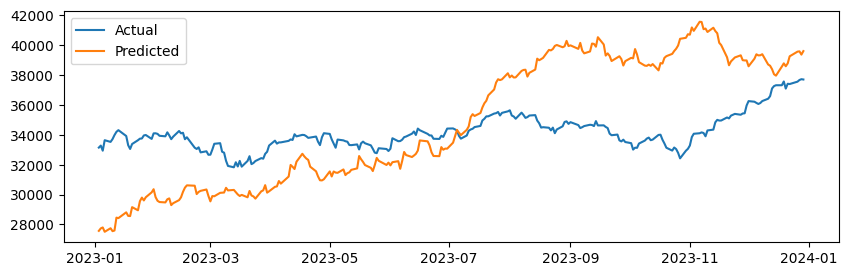

In [ ]:
from sklearn.linear_model import LinearRegression

# Build Model
linear_reg = make_pipeline(
    LinearRegression()
).fit(X_train, y_train)

# Printing Cross Validation Score
cvs_linear_reg = cross_val_score(linear_reg, X_train, y_train, cv = 5, n_jobs = -1)
print("Linear Regression Scores: " + str(cvs_linear_reg))

# Grid Search Params
linear_reg_params = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__copy_X": [True, False],
    "linearregression__positive": [True, False]
}

# Grid Search Cross Validation
linear_reg_model = GridSearchCV(
    linear_reg,
    linear_reg_params,
    cv = 5,
    n_jobs = -1,
    verbose = 1,
    scoring = "r2"
).fit(X_train, y_train)

# Print the Best Score and Best Params
print(linear_reg_model.best_score_)
print(linear_reg_model.best_params_)

# Linear Regression
linear_reg = LinearRegression(fit_intercept = True, copy_X = True, positive = True)
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)

print("MSE", mean_squared_error(y_test, y_pred_linear))
print("R2", r2_score(y_test, y_pred_linear))

plt.figure(figsize = (10, 3))
plt.plot(y_test, label = "Actual")
plt.plot(y_test.index, y_pred_linear, label = "Predicted")
plt.legend();

#### **3.6.3.2 Ridge Regression**

Ridge Regression Scores: [-5.07237433 -1.05002417 -1.64370392 -9.67676721 -5.40497108]
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
-3.9540400832548195
{'ridge__alpha': 0.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__positive': False, 'ridge__solver': 'lsqr'}
MSE 1379528.670791252
R2 0.0005844554709146799


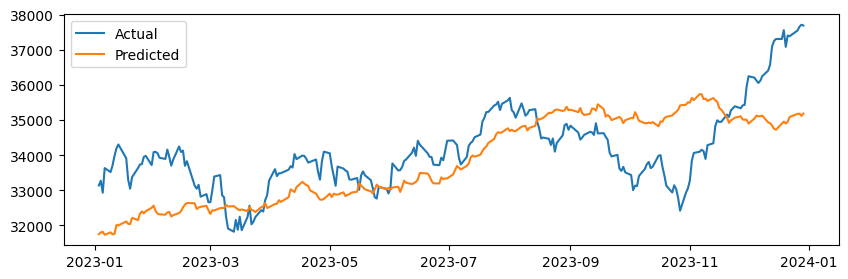

In [ ]:
from sklearn.linear_model import Ridge

# Build Normal Model
ridge_reg = make_pipeline(
    Ridge(random_state = 42)
).fit(X_train, y_train)

# Printing Cross Validation Score
cvs_ridge_reg = cross_val_score(ridge_reg, X_train, y_train, cv = 5, n_jobs = -1)
print("Ridge Regression Scores: " + str(cvs_ridge_reg))

# Grid Search Params
ridge_reg_params = {
    "ridge__alpha": np.arange(0.0, 2, 0.2),
    "ridge__fit_intercept": [True, False],
    "ridge__copy_X": [True, False],
    "ridge__solver": ["auto", "svd", "cholesky", "lsqr", "sparce_cg", "sag", "saga", "lbfgs"],
    "ridge__positive": [True, False]
}

# Grid Search Cross Validation
ridge_reg_model = GridSearchCV(
    ridge_reg,
    ridge_reg_params,
    cv = 5,
    n_jobs = -1,
    verbose = 1,
    scoring = "r2"
).fit(X_train, y_train)

# Print the Best Score and Best Params
print(ridge_reg_model.best_score_)
print(ridge_reg_model.best_params_)

ridge = Ridge(alpha = 0.0, copy_X = True, fit_intercept = True, positive = False, solver = "lsqr", random_state = 42)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("MSE", mean_squared_error(y_test, y_pred_ridge))
print("R2", r2_score(y_test, y_pred_ridge))

plt.figure(figsize = (10, 3))
plt.plot(y_test, label = "Actual")
plt.plot(y_test.index, y_pred_ridge, label = "Predicted")
plt.legend();

#### **3.6.3.3 Lasso Regression**

Lasso Regression Scores: [-4.83489243 -0.82770389 -1.73032294 -9.09022416 -4.94403292]
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
-4.0973474593289305
{'lasso__alpha': 0.0, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__positive': False, 'lasso__precompute': False, 'lasso__selection': 'cyclic', 'lasso__warm_start': True}
MSE 9592550.084970737
R2 -5.94943415789597


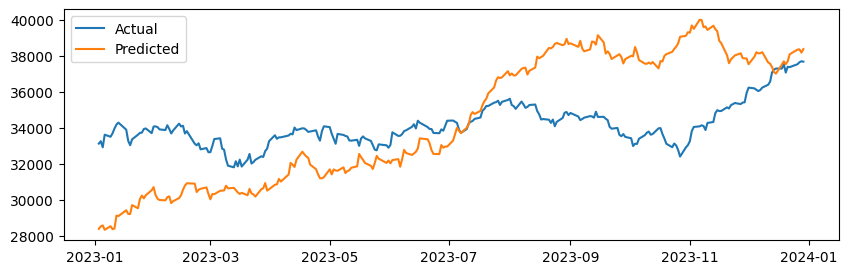

In [ ]:
from sklearn.linear_model import Lasso

# Build Normal Model
lasso_reg = make_pipeline(
    Lasso(random_state = 42)
).fit(X_train, y_train)

# Printing Cross Validation Score
cvs_lasso_reg = cross_val_score(lasso_reg, X_train, y_train, cv = 5, n_jobs = -1)
print("Lasso Regression Scores: " + str(cvs_lasso_reg))

# Grid Search Params
lasso_reg_params = {
    "lasso__alpha": np.arange(0.0, 2, 0.2),
    "lasso__fit_intercept": [True, False],
    "lasso__precompute": [True, False],
    "lasso__copy_X": [True, False],
    "lasso__warm_start": [True, False],
    "lasso__positive": [True, False],
    "lasso__selection": ["cyclic", "random"]
}

# Grid Search Cross Validation
lasso_reg_model = GridSearchCV(
    lasso_reg,
    lasso_reg_params,
    cv = 5,
    n_jobs = -1,
    verbose = 1,
    scoring = "r2"
).fit(X_train, y_train)

# Print the Best Score and Best Params
print(lasso_reg_model.best_score_)
print(lasso_reg_model.best_params_)

lasso = Lasso(alpha = 0.0, copy_X = True, fit_intercept = True, positive = False, precompute = False, selection = "cyclic", warm_start = True, random_state = 42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("MSE", mean_squared_error(y_test, y_pred_lasso))
print("R2", r2_score(y_test, y_pred_lasso))

plt.figure(figsize = (10, 3))
plt.plot(y_test, label = "Actual")
plt.plot(y_test.index, y_pred_lasso, label = "Predicted")
plt.legend();

#### **3.6.3.4 ElasticNet Regression**

ElasticNet Regression Scores: [ -6.87771536  -1.46137803 -20.98607566  -9.68697813  -1.43827533]
Fitting 5 folds for each of 6400 candidates, totalling 32000 fits
-4.0973474593289305
{'elasticnet__alpha': 0.0, 'elasticnet__copy_X': True, 'elasticnet__fit_intercept': True, 'elasticnet__l1_ratio': 0.0, 'elasticnet__positive': False, 'elasticnet__precompute': False, 'elasticnet__selection': 'cyclic', 'elasticnet__warm_start': True}
MSE 4629680.853066841
R2 -2.354025986360832


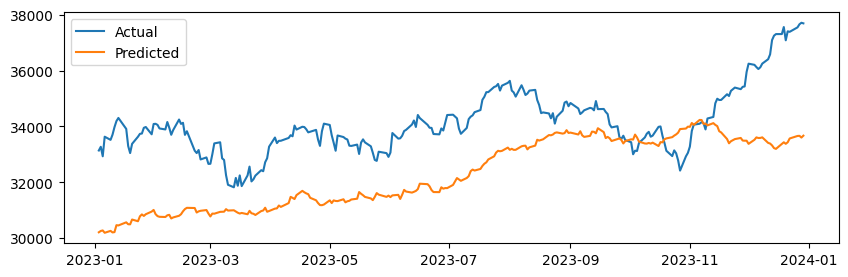

In [ ]:
from sklearn.linear_model import ElasticNet

# Build Normal Model
elasticnet_reg = make_pipeline(
    ElasticNet(random_state = 42)
).fit(X_train, y_train)

# Printing Cross Validation Score
cvs_elasticnet_reg = cross_val_score(elasticnet_reg, X_train, y_train, cv = 5, n_jobs = -1)
print("ElasticNet Regression Scores: " + str(cvs_elasticnet_reg))

# Grid Search Params
elasticnet_reg_params = {
    "elasticnet__alpha": np.arange(0.0, 2, 0.2),
    "elasticnet__l1_ratio": np.arange(0.0, 1, 0.1),
    "elasticnet__fit_intercept": [True, False],
    "elasticnet__precompute": [True, False],
    "elasticnet__copy_X": [True, False],
    "elasticnet__warm_start": [True, False],
    "elasticnet__positive": [True, False],
    "elasticnet__selection": ["cyclic", "random"]
}

# Grid Search Cross Validation
elasticnet_reg_model = GridSearchCV(
    elasticnet_reg,
    elasticnet_reg_params,
    cv = 5,
    n_jobs = -1,
    verbose = 1,
    scoring = "r2"
).fit(X_train, y_train)

# Print the Best Score and Best Params
print(elasticnet_reg_model.best_score_)
print(elasticnet_reg_model.best_params_)

elasticnet = ElasticNet(alpha = 0.0, copy_X = True, fit_intercept = True, l1_ration = 0.0, positive = False, precompute = False, selection = "cyclic", warm_start = True, random_state = 42)
elasticnet.fit(X_train, y_train)
y_pred_elasticnet = elasticnet.predict(X_test)

print("MSE", mean_squared_error(y_test, y_pred_elasticnet))
print("R2", r2_score(y_test, y_pred_elasticnet))

plt.figure(figsize = (10, 3))
plt.plot(y_test, label = "Actual")
plt.plot(y_test.index, y_pred_elasticnet, label = "Predicted")
plt.legend();

#### **3.6.3.5 Adding Polynomial Features**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Add polynomial features to capture non-linear relationships
poly = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# 1. Linear Regression with Polynomial Features
linear_reg = LinearRegression(fit_intercept = True, copy_X = True, positive = True)
linear_reg.fit(X_train_poly, y_train)
y_pred_linear = linear_reg.predict(X_test_poly)

# 2. Ridge Regression with Polynomial Features
ridge = Ridge(alpha = 0.0, copy_X = True, fit_intercept = True, positive = False, solver = "lsqr", random_state = 42)
ridge_reg.fit(X_train_poly, y_train)
y_pred_ridge = ridge_reg.predict(X_test_poly)

# 3. Lasso Regression with Polynomial Features
lasso = Lasso(alpha = 0.0, copy_X = True, fit_intercept = True, positive = False, precompute = False, selection = "cyclic", warm_start = True, random_state = 42)
lasso_reg.fit(X_train_poly, y_train)
y_pred_lasso = lasso_reg.predict(X_test_poly)

# 4. ElasticNet Regression with Polynomial Features
elasticnet = ElasticNet(alpha = 0.0, copy_X = True, fit_intercept = True, positive = False, precompute = False, selection = "cyclic", warm_start = True, random_state = 42)
elasticnet_reg.fit(X_train_poly, y_train)
y_pred_elasticnet = elasticnet_reg.predict(X_test_poly)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R^2: {r2:.4f}")

# Evaluate each model
evaluate_model(y_test, y_pred_linear, "Linear Regression with Polynomial Features")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression with Polynomial Features")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression with Polynomial Features")
evaluate_model(y_test, y_pred_elasticnet, "ElasticNet Regression with Polynomial Features")

Linear Regression with Polynomial Features - MSE: 14774830.1357, R^2: -9.7038
Ridge Regression with Polynomial Features - MSE: 11859760.3488, R^2: -7.5919
Lasso Regression with Polynomial Features - MSE: 11047270.2578, R^2: -7.0033
ElasticNet Regression with Polynomial Features - MSE: 9698854.4446, R^2: -6.0264


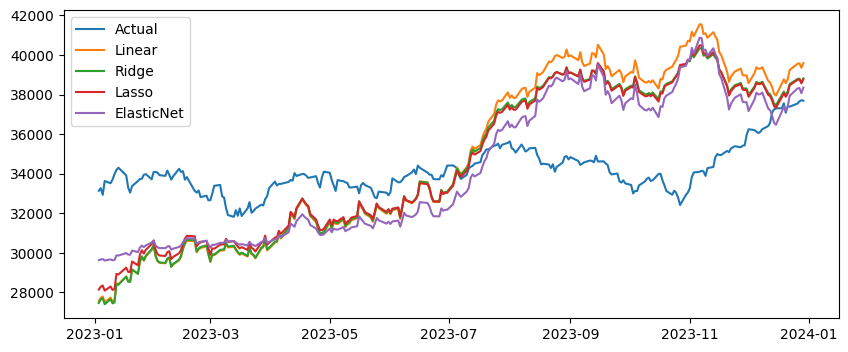

In [ ]:
plt.plot(y_test, label = "Actual")
plt.plot(y_test.index, y_pred_linear, label = "Linear")
plt.plot(y_test.index, y_pred_ridge, label = "Ridge")
plt.plot(y_test.index, y_pred_lasso, label = "Lasso")
plt.plot(y_test.index, y_pred_elasticnet, label = "ElasticNet")
plt.legend();